# Determining the age of customers

A chain supermarket is launching a computer vision system to process customer photos. Photo fixation in the checkout area will help to determine the age of customers in order to:
Analyze purchases and suggest products that may be of interest to customers in this age group;
Monitor the integrity of cashiers when selling alcohol.
We will build a model that determines the approximate age of a person from a photograph. We have at our disposal a set of photographs of people with their ages.

<a id="0"></a> <br>
# Table of Contents  
1. [Exploratory data analysis](#1)
2. [Model training](#2)
    1. [Model Code](#2.1)
    2. [Console output](#2.2)
3. [Analyzing the trained model](#3)

<a id="1"></a>
## Exploratory data analysis
[Back to the top](#0)

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


To improve the quality of the models further, we increase the sampling of images using augmentations.

In [3]:
labels.shape

(7591, 2)

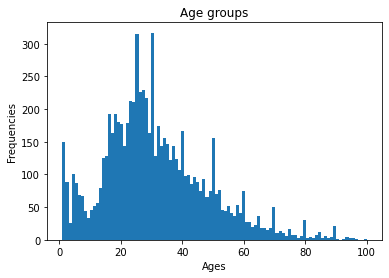

In [5]:
plt.hist(labels['real_age'], bins =100)
plt.xlabel('Ages')
plt.ylabel('Frequencies')
plt.title('Age groups')
plt.show()

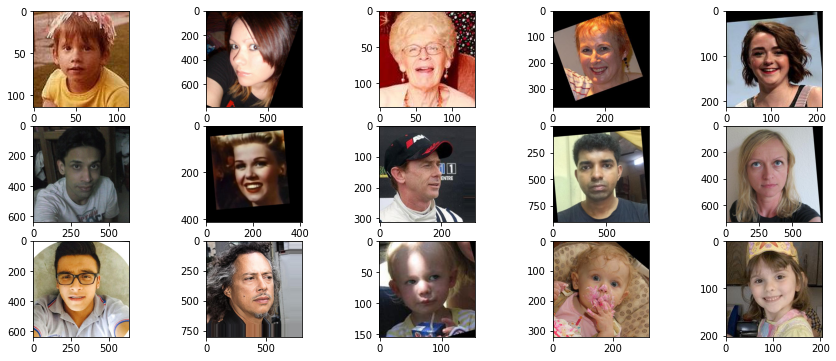

In [6]:
fig, ax = plt.subplots(3, 5, figsize=(15, 6))
с = 0
for i in range(3):
    for j in range(5):
        image = Image.open('/datasets/faces/final_files/' + labels.iloc[с]['file_name'])
        array = np.array(image)
        ax[i][j].imshow(array)
        с = с + 1

In [7]:
labels.head(15)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


The dataset contains 7591 records. With this amount of data, it would be difficult to build models with high predictive accuracy.

Most of the information is about people between 18 and 40 years old, there are also pictures of children and elderly people, but in smaller numbers. Thus, the dataset contains information about people of all age groups, which will have a positive impact on the quality of future models.

By comparing the people in the picture and their age in `real_age` in the dataset, we can conclude that the data in the table is true. Hence, this dataset can be used for model training.

Based on the resulting sample, it is clear that there are nested images, things or body parts covering the face. All this makes it difficult to determine the age.

Moreover, it's worth mentioning:    
    
 - The images are square
 - In the center of the images there are close-up faces taken from different angles ( front, profile, half-turn).
 - There are black and white and color photos.
 - Some photos have side objects covering part of the face.
 - The images have been rotated, probably in order to align the photo vertically.

<a id="2"></a>
## Model training
[Back to the top](#0)

<a id="2.1"></a>
### Model Code
[Back to the top](#0)

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd
 
 
def load_train(path):
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True,
    height_shift_range=0.2)
    
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
    
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
    
    return test_datagen_flow
 

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', 
              metrics=['mae'])
 
    return model
 
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
          validation_data=test_data,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          batch_size=batch_size, epochs=epochs,
          verbose=2, shuffle=True)
 
    return model

```

<a id="2.2"></a>
### Console output
[Back to the top](#0)

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

356/356 - 127s - loss: 205.9962 - mae: 10.5381 - val_loss: 543.2864 - val_mae: 18.2127
Epoch 2/10
356/356 - 102s - loss: 95.4857 - mae: 7.3866 - val_loss: 132.5289 - val_mae: 8.6054
Epoch 3/10
356/356 - 101s - loss: 72.0449 - mae: 6.4841 - val_loss: 90.6327 - val_mae: 7.0705
Epoch 4/10
356/356 - 102s - loss: 61.3478 - mae: 6.0220 - val_loss: 88.8972 - val_mae: 6.9559
Epoch 5/10
356/356 - 99s - loss: 48.2701 - mae: 5.3271 - val_loss: 103.1197 - val_mae: 7.8777
Epoch 6/10
356/356 - 103s - loss: 40.9934 - mae: 4.9478 - val_loss: 96.5550 - val_mae: 7.6173
Epoch 7/10
356/356 - 103s - loss: 35.5088 - mae: 4.5384 - val_loss: 71.6811 - val_mae: 6.2698
Epoch 8/10
356/356 - 101s - loss: 29.1608 - mae: 4.1584 - val_loss: 69.2819 - val_mae: 6.2882
Epoch 9/10
356/356 - 102s - loss: 26.7005 - mae: 4.0005 - val_loss: 65.1747 - val_mae: 6.0526
Epoch 10/10
356/356 - 101s - loss: 22.1917 - mae: 3.6415 - val_loss: 68.1243 - val_mae: 6.1997

119/119 - 11s - loss: 68.1243 - mae: 6.1997
Test MAE: 6.1997

```

Using a convolutional neural network model built on the ResNet 50 architecture, it was possible to obtain an MAE metric value of 6.63 on the test sample at 3 epochs, which is a good indication of the accuracy of the model.

<a id="3"></a>
## Analyzing the trained model
[Back to the top](#0)

The model is able to predict the age of buyers based on their photos quite accurately. The value of the MAE 6-7 years error is insignificant, as the categories of buyers are mainly formed in the interval of 10-12 years.

In this project, the ResNet50 model was used for age prediction, while:
- backbone architecture + newly constructed "top", pre-trained weights were used;
- batches of size 16, Adam optimizer, 10 epochs were used, no freezing of backbon weights was performed;
- MAE metric value of 6.19 was achieved, overtraining was observed.